In [1]:
using JuMP, Cbc, Plots     # The usual packages
using DelimitedFiles       # IO reading/writing files
using LinearAlgebra        # For convenience (includes function norm(x))
using Combinatorics        # To perform permutations

# MS-E2121 - Linear optimization
## Exercise session 8



### Demo exercise: Travelling salesman problem (TSP) - MTZ formulation
#### Examining the formulation

Show that the following formulation $P_{MTZ}$ is valid for the TSP defined on a directed graph $G = (N,A)$ with $N = \{1,\dots,n\}$ cities and arcs $A = \{(i,j) : i,j\in N, i\neq j\}$ between cities.
$$
P_{MTZ} = \left\{
   \begin{array}{ll}
   \displaystyle \sum_{j \in N \setminus \{i\}} x_{ij} = 1, & \forall i \in N \\
   \displaystyle \sum_{j \in N \setminus \{i\}} x_{ji} = 1, & \forall i \in N \\   
   \displaystyle u_{i} - u_{j} + (n-1) x_{ij} \leq n - 2, & \forall i,j \in N \setminus \{ 1 \} : i \neq j ~~(*)\\
    x_{ij} \in \{0,1\}, & \forall i,j \in N : i\neq j\\
  \end{array}
\right.
$$

where $x_{ij} = 1$ if city $j\in N$ is visited immediately after city $i \in N$, and $x_{ij} = 0$ otherwise. Constraints $(*)$ with the variables $u_i \in \mathbb{R}$ for all $i\in N$ are called *Miller-Tucker-Zemlin* (MTZ) subtour elimination constraints.


We want to show that
1. Constraints $(*)$ prevent subtours in any solution $x \in P_{MTZ}$.
2. Every TSP solution $x$ satisfies the constraints $(*)$.

To prove the first one, we first assume that a solution $x \in P_{MTZ}$ *has* a subtour with $k$ nodes and $k$ arcs between them, not going through node 1. For example, assume nodes 2, 3 and 5 form a subtour when $n=5$. Let's write the constraints $(*)$ corresponding to this subtour:

\begin{align}
    u_2 - u_3 + 4 \le 3 \\
    u_3 - u_5 + 4 \le 3 \\
    u_5 - u_2 + 4 \le 3
\end{align}

We observe that if $x_{ij} = 1$ such that $i,j \in N \setminus 1$, the constraint $(*)$ can be written as $u_i \le u_j - 1$, which for integer variables is the same as $u_i < u_j$. For a general result, we denote the nodes in the subtour by $\{i_1, ..., i_k\}$ and get $u_{i_1} < u_{i_k} < u_{i_1}$, which is a contradiction. This tells us that there can be no subtour ($k<n$) that doesn't contain node 1. A subtour containing node 1 would imply another subtour not containing node 1, so that is also forbidden by $(*)$. This proves the first part.



For the second part, we notice that the $u$-variables seem to imply an ordering for the nodes. Assume that all tours start from node 1 and $u_i, \ i \in N \setminus 1$ is the position of the node on the tour (the first node visited after the starting node 1 has $u$-value 2, the second one 3 and so on). For each arc $i \rightarrow j$, we have either $x_{ij}=0$ or $x_{ij}=1$.

If $x_{ij} = 0$: there is no arc from $i$ to $j$, and the constraint is $u_{i} - u_{j} \leq n - 2$, which holds, since we defined that $i$ and $j$ can't be 1, and also not greater than $n$. The upper bound of the difference between two $u$-values is thus $n-2$, and the constraint always holds if $x_{ij}=0$.

If $x_{ij} = 1$: there is an arc from $i$ to $j$, and the constraint is $u_{i} - u_{j} + n-1 \leq n - 2$ or $u_{i} - u_{j} \leq -1$, which looks familiar from before and actually holds when we do not have subtours since by our definition, $u_i - u_j = -1$. The key is that this time, we have no subtours that do not contain node 1, which is treated as a special case.

To conclude, we proved that this formulation does not allow subtours, and all valid solutions $x$ satisfy the constraints. Therefore, the formulation is valid.

#### MTZ and naive TSP implementation
We first write some helper functions, starting with one that computes the distances between coordinates:

In [2]:
## Function for getting the distances array
function get_dist(xycoord::Matrix{},n::Int)
    # Compute distance matrix (d[i,j]) from city coordinates
    
    dist = zeros(n,n)
    for i = 1:n
        for j = i:n
            d = norm(xycoord[i,:] - xycoord[j,:])
            dist[i,j] = d
            dist[j,i] = d
        end
    end
    return dist
end

get_dist (generic function with 1 method)

A function to convert the adjacency matrix $x$ describing a tour to a vector representing the tour, starting from city 1.

In [3]:
# Get the optimal tour
# Input
#     x: solution matrix 
#     n: number of cities
# Returns
#     tour: ordering of cities in the optimal tour
function gettour(x::Matrix{Int}, n::Int)
    tour = zeros(Int,n+1)   # Initialize tour vector (n+1 as city 1 appears twice)
    tour[1] = 1             # Set city 1 as first one in the tour
    k = 2                   # Index of vector tour[k]
    i = 1                   # Index of current city 
    while k <= n + 1        # Find all n+1 tour nodes (city 1 is counted twice)
        for j = 1:n         
            if x[i,j] == 1  # Find next city j visited immediately after i
                tour[k] = j # Set city j as the k:th city in the tour
                k = k + 1   # Update index k of tour[] vector
                i = j       # Move to next city
                break       
            end
        end
    end 
    return tour             # Return the optimal tour 
end

gettour (generic function with 1 method)

In [4]:
## Defining the colors to be used
c_blue = palette(:auto)[1]                         # color :1
c_orange = palette(:auto)[2]                       # color :2
c_green = palette(:auto)[3];                       # color :3

The data is stored in csv-files, a common external data format. We use the DelimitedFiles package to read a file into a matrix ```data```.

In [5]:
# "data16a.csv" has 3 columns which are stored in (Nullable) Arrays
# data[1], data[2], data[3] after the function call
# data = CSV.read(...) below. The columns contain:
#
#     data[:,1]: all cities i in V
#     data[:,2]: x-coordinate of each city i in V
#     data[:,3]: y-coordinate of each city i in V
#

data  = readdlm("data16a.csv", ',')   
# data  = readdlm("data16b.csv", ',')   
n = 16                  # number of cities 
# println(data)         # Look at the data in compact form
V = data[2:n+1,1]       # All cities i in V
x = data[2:n+1,2]       # x-coordinates of cities i in V
y = data[2:n+1,3]       # y-coordinates of cities i in V
xycoord = [x y];        # n x 2 coordinate matrix

In [6]:
function tsp_naive(xycoord::Matrix{}, n::Int)
    
    # Create a model 
    m = Model(Cbc.Optimizer)  
    
    # Here the costs c are the distances between cities
    c = get_dist(xycoord,n)
    
    ## Variables

    # x[i,j] = 1 if we travel from city i to city j, 0 otherwise.
    @variable(m, x[1:n,1:n], Bin)
    
    ## Objective
    
    # Minimize length of tour
    @objective(m, Min, dot(c,x))

    ## Constraints
    
    # Ignore self arcs: set x[i,i] = 0  
    @constraint(m, sar[i = 1:n], x[i,i] == 0)

    # We must enter and leave every city exactly once             
    @constraint(m, ji[i = 1:n], sum(x[j,i] for j = 1:n if j != i) == 1)
    @constraint(m, ij[i = 1:n], sum(x[i,j] for j = 1:n if j != i) == 1)

    optimize!(m)
                                
    cost = objective_value(m)         # Optimal cost (length)
    sol_x = round.(Int, value.(x))    # Optimal solution vector
    
    return m, sol_x, cost
end;

In [7]:
## Solve the problem and evaluate time and memory with @time macro
(m_naive, x_naive, cost_naive) = @time tsp_naive(xycoord, n);

# Get the optimal tour
tour_naive = gettour(x_naive,n);

 25.801976 seconds (57.71 M allocations: 2.882 GiB, 6.41% gc time)
Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 14779.5 - 0.00 seconds
Cgl0002I 16 variables fixed
Cgl0004I processed model has 32 rows, 240 columns (240 integer (240 of which binary)) and 480 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 14779.5
Cbc0038I Before mini branch and bound, 240 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.02 seconds)
Cbc0038I After 0.02 seconds - Feasibility pump exiting with objective of 14779.5 - took 0.01 seconds
Cbc0012I Integer solution of 14779.476 found by feasibility pump after 0 iterations and 0 nodes (0.03 seconds)
Cbc0001I Search completed - best objective 14779.47644152248, took 0 iterations and 0 nodes (0.03 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed 

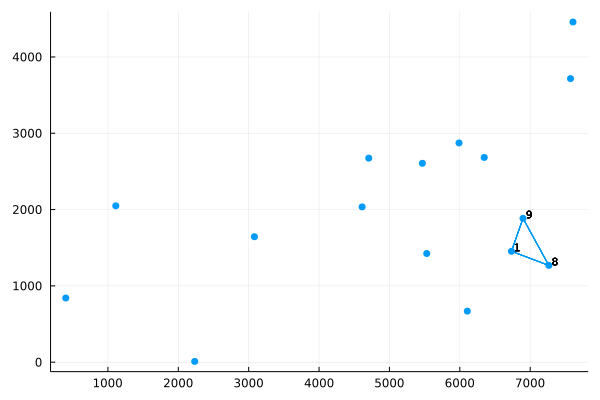

In [8]:
plt = scatter(xycoord[:,1],xycoord[:,2], 
      markercolor = c_blue,
      markerstrokewidth = 0,
      legend = false
)
for i in 1:length(tour_naive)-1
    annotate!(xycoord[tour_naive[i],1]+50, xycoord[tour_naive[i],2]+50, ("$(tour_naive[i])", 7, :left))
    plot!(([xycoord[tour_naive[i],1],xycoord[tour_naive[i+1],1]] , [xycoord[tour_naive[i],2],xycoord[tour_naive[i+1],2]]), c = c_blue, label = "")
end
plt

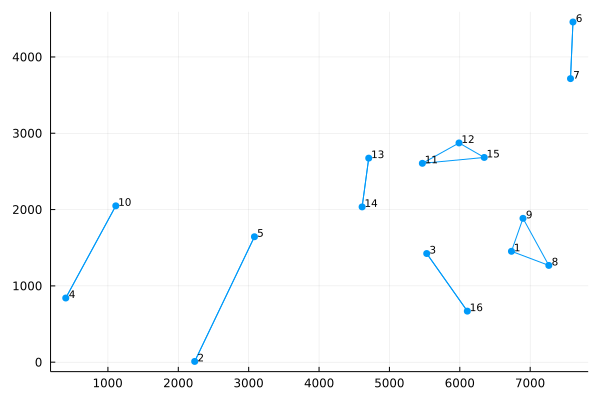

In [9]:
plt = scatter(xycoord[:,1],xycoord[:,2], 
      markercolor = c_blue,
      markerstrokewidth = 0,
      legend = false
)
for i in 1:n
    annotate!(xycoord[i,1]+50, xycoord[i,2]+50, ("$(i)", 7, :left))
    for j in 1:n
        if x_naive[i,j] == 1
            plot!(([xycoord[i,1],xycoord[j,1]] , [xycoord[i,2],xycoord[j,2]]), c = c_blue, label = "")
            break
        end
    end
end
plt

In [10]:
# Solve a directed, TSP instance (MTZ formulation)
# Input
#    xycoord: coordinates of city locations
#    n: number of cities
# Returns
#    tour: ordering of cities in the optimal tour
#    cost: cost (length) of the optimal tour
function tsp_mtz(xycoord::Matrix{}, n::Int)
    
    # Create a model 
    m = Model(Cbc.Optimizer)  
    
    # Here the costs c are the distances between cities
    c = get_dist(xycoord,n)
    
    ## Variables

    # x[i,j] = 1 if we travel from city i to city j, 0 otherwise.
    @variable(m, x[1:n,1:n], Bin)
    # Variables u for subtour elimination constraints
    @variable(m, u[2:n])   
    
    ## Objective
    
    # Minimize length of tour
    @objective(m, Min, dot(c,x))

    ## Constraints
    
    # Ignore self arcs: set x[i,i] = 0  
    @constraint(m, sar[i = 1:n], x[i,i] == 0)

    # We must enter and leave every city exactly once             
    @constraint(m, ji[i = 1:n], sum(x[j,i] for j = 1:n if j != i) == 1)
    @constraint(m, ij[i = 1:n], sum(x[i,j] for j = 1:n if j != i) == 1)
                                    
    # MTZ subtour elimination constraints
    @constraint(m, sub[i = 2:n, j = 2:n, i != j], u[i] - u[j] + (n-1)*x[i,j] <= (n-2))
                                
    optimize!(m)
                                
    cost = objective_value(m)         # Optimal cost (length)
    sol_x = round.(Int, value.(x))    # Optimal solution vector
    
    return m, sol_x, cost
end;

In [11]:
## Solve the problem and evaluate time and memory with @time macro
(m_mtz, x_mtz, cost_mtz) = @time tsp_mtz(xycoord, n);

# Get the optimal tour
tour_mtz = gettour(x_mtz,n);      

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 15273.6 - 0.00 seconds
Cgl0002I 16 variables fixed
Cgl0004I processed model has 242 rows, 255 columns (240 integer (240 of which binary)) and 1110 elements
Cbc0038I Initial state - 29 integers unsatisfied sum - 2.4
Cbc0038I Pass   1: suminf.    1.73333 (19) obj. 16862 iterations 48
Cbc0038I Pass   2: suminf.    1.73333 (7) obj. 38620.3 iterations 54
Cbc0038I Pass   3: suminf.    1.73333 (10) obj. 37603.8 iterations 20
Cbc0038I Pass   4: suminf.    1.73333 (11) obj. 37200.1 iterations 18
Cbc0038I Pass   5: suminf.    1.73333 (9) obj. 43903.4 iterations 38
Cbc0038I Pass   6: suminf.    1.73333 (14) obj. 43717.4 iterations 15
Cbc0038I Pass   7: suminf.    1.73333 (11) obj. 37517.3 iterations 36
Cbc0038I Pass   8: suminf.    2.80000 (6) obj. 39892.6 iterations 34
Cbc0038I Pass   9: suminf.    1.73333 (10) obj. 36107 iterat

In [12]:
## Print the optimal tour and its cost
println("\nOptimal tour: $(tour_mtz)\n")
println("Optimal length: ", cost_mtz)


Optimal tour: [1, 8, 9, 7, 6, 15, 12, 11, 13, 14, 5, 10, 4, 2, 3, 16, 1]

Optimal length: 21098.729848051342


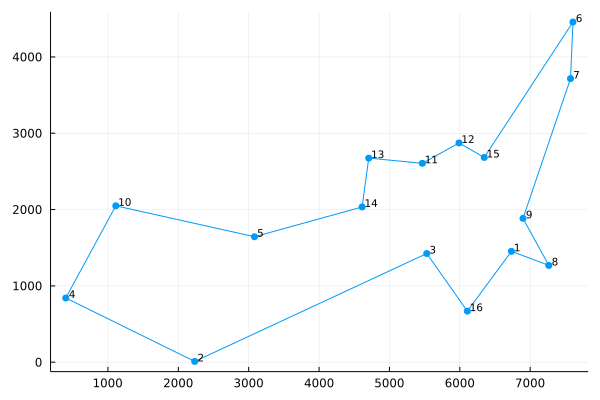

In [13]:
plt = scatter(xycoord[:,1],xycoord[:,2], 
      markercolor = c_blue,
      markerstrokewidth = 0,
      legend = false
)
for i in 1:length(tour_mtz)-1
    annotate!(xycoord[tour_mtz[i],1]+50, xycoord[tour_mtz[i],2]+50, ("$(tour_mtz[i])", 7, :left))
    plot!(([xycoord[tour_mtz[i],1],xycoord[tour_mtz[i+1],1]] , [xycoord[tour_mtz[i],2],xycoord[tour_mtz[i+1],2]]), c = c_blue, label = "")
end
plt

Now that we have solved the problem using the MTZ formulation, let's try solving the same problem starting with the naive implementation and using successive cutset or subtour elimination constraints:

In [14]:
## Initialisation
(m_naive, x_naive, cost_naive) = tsp_naive(xycoord, n);
subnodes = []
count = 0
stop = 0
lim = 100
methods = [:elimination,:cutset]
method = methods[2];

## Perform cuts to break subtours until we got an optimal
@time while stop == 0 && count < lim

    S = collect(permutations(subnodes,2))     # Possible connections present in the naive implementation
    NS = setdiff(V,subnodes)                  # Nodes that are still not included in the tour

    if method == :cutset
        ## Cutset constraints
        if length(S) > 0
            @constraint(m_naive,sum(m_naive[:x][subnodes[i],NS[j]] for i in 1:length(subnodes), j in 1:length(NS)) >= 1)
        end
    else
        ## Subtour elimination constraints
        if length(S) > 0
            @constraint(m_naive,sum(m_naive[:x][S[i][1],S[i][2]] for i in 1:length(S)) <= length(subnodes)-1)
        end
    end

    set_silent(m_naive)
    optimize!(m_naive)

    cost2 = objective_value(m_naive)          # Optimal cost (length)
    sol_x = round.(Int, value.(m_naive[:x]))     # Optimal solution vector

    tour2 = gettour(sol_x,n)            # Get the optimal tour
    
    if length(unique(tour2)) < n
        count = count + 1
        println("Method used: ",method)
        println("Subtours present in node 1, update subnodes vector to break the subtour: ", tour2')
        println("\nIteration $(count); not optimal.\n")
        subnodes = unique(tour2);
    else
        println("Method used: ",method)
        println("Optimal tour: ", tour2')
        println("\n Took $(count) iterations to find the optimal solution.")
        S = []
        stop = 1
    end;
end;

Method used: cutset
Subtours present in node 1, update subnodes vector to break the subtour: [1 9 8 1 9 8 1 9 8 1 9 8 1 9 8 1 9]

Iteration 1; not optimal.

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 14779.5 - 0.00 seconds
Cgl0002I 16 variables fixed
Cgl0004I processed model has 32 rows, 240 columns (240 integer (240 of which binary)) and 480 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 14779.5
Cbc0038I Before mini branch and bound, 240 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve solution (0.01 seconds)
Cbc0038I After 0.01 seconds - Feasibility pump exiting with objective of 14779.5 - took 0.01 seconds
Cbc0012I Integer solution of 14779.476 found by feasibility pump after 0 iterations and 0 nodes (0.01 seconds)
Cbc0001I Search completed - best objective 14779.47644152248,

### Scheduling problem
<!---%--->
One way to formulate the scheduling problem is to use the job start times $t_j \ge 0$ as the decision variables and then define constraints for making sure two jobs are not done simultaneously. From the problem description, it is clear that the objective is to minimize $\sum_{j=1}^{n}w_jt_j$. For the constraints, we add binary variables $x_{ij}$ such that $x_{ij}=1$ if and only if job $i$ is done at some point before job $j$. We want the following two implications to hold:
\begin{align}
    x_{ij} = 1 \Rightarrow t_j \ge t_i + p_i \\
    x_{ij} = 0 \Rightarrow t_i \ge t_j + p_j
\end{align}

We will then model these implications using a disjunctive big-M formulation (see the ULS problem in Lecture 8). 

\begin{align}
    t_i - t_j + p_i &\le M(1-x_{ij}), \ &\forall i,j \in \{1,...,n\}: i \neq j \\
    t_j - t_i + p_j &\le Mx_{ij}, \ &\forall i,j \in \{1,...,n\}: i \neq j
\end{align}

If we then define a large enough big-M ($M \ge t_i - t_j + p_j, \ \forall i,j \in \{1,...,n\}: i \neq j$), these constraints correspond to what we wanted and we have our formulation.

\begin{align}
    \text{min. } &\sum_{j=1}^{n}w_jt_j \\
    \text{s.t. }&t_i - t_j + p_i \le M(1-x_{ij}), \ \forall i,j \in \{1,...,n\}: i \neq j \\
    &t_j - t_i + p_j \le Mx_{ij}, \ \forall i,j \in \{1,...,n\}: i \neq j \\
    &t_j \ge 0, \ \forall j \in \{1,...,n\} \\
    &x_{ij} \in \{0,1\}, \ \forall i,j \in \{1,...,n\}: i \neq j
\end{align}
<!---%--->